# Time Series Forecast

In this workbook we will predict meat supply for Austraila using the ARIMA technique. ARIMA (AutoRegressive Integrated Moving Average) is used for analyzing and forecasting time series data.

Components of the model are the following:

- AR: Autoregression. Uses the dependent relationship between an observation and some number of lagged observations.
- I: Integrated. The use of differencing raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- MA: Moving Average. Uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified as a model parameter:

- p: The number of lag (_delay that shows how similar the time series is with itself_ ) observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

## Import packages, read in data and filter Australia

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from matplotlib.pyplot import figure
plt.style.use('fivethirtyeight')

%matplotlib inline

## Prevent obnoxious warning messages
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [68]:
df = pd.read_csv('FAO.csv',encoding='ISO-8859-1')

In [9]:
au = df[df['Area']=='Australia']
au.shape

(128, 63)

### Any missing data?

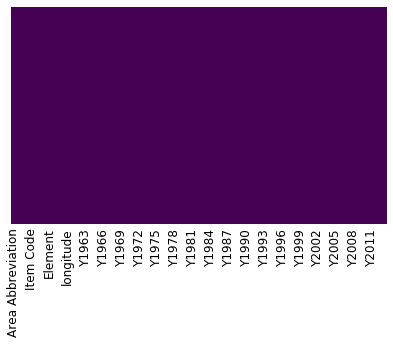

In [71]:
sns.heatmap(au.isnull(),cmap='viridis',yticklabels=False,cbar=False)

### Meat Data Preprocessing

Before we can run the model we need to prep a dataset that has ```year``` and ```amount supplied```.

In [87]:
au_food = au[au['Element']=='Food']
meat = au_food[au_food['Item']=='Meat']
meat

,Area Abbreviation,Area Code,Area,Item Code,Item,Element Code,Element,Unit,latitude,longitude,...,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013
929,AUS,10,Australia,2943,Meat,5142,Food,1000 tonnes,-25.27,133.78,...,2178.0,2407.0,2333.0,2594.0,2432.0,2474.0,2508.0,2754.0,2704,2713


In [88]:
meat = meat.T[10:].reset_index()
meat = meat.rename(columns={'index':'year',929:'amount'})
meat['year'] = pd.to_datetime(meat['year'].str.strip('Y'))
meat['amount'] = meat['amount'].astype('float')
meat = meat.set_index('year')
meat.head(3)

,amount
year,
1961-01-01,1102.0
1962-01-01,1202.0
1963-01-01,1226.0


## Meat Supply Over Time

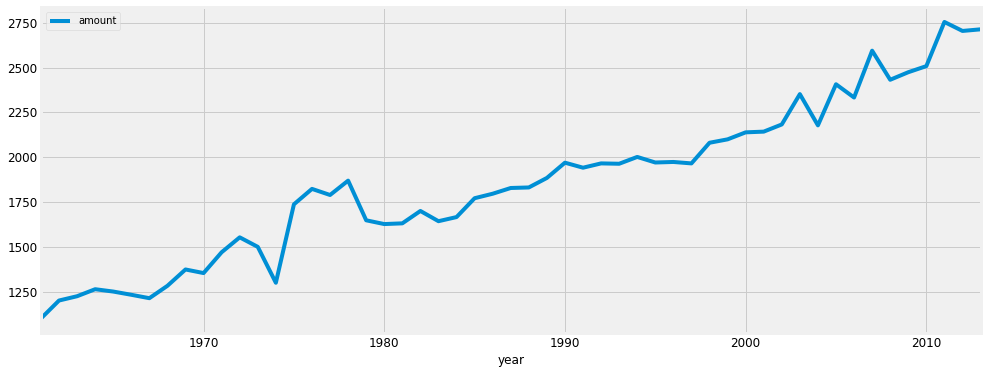

In [89]:
meat.plot(figsize=(15, 6))

- We can see a clear rising trend in meat supply. This suggests that the time series is not stationary and will require differencing to make it stationary, a difference order of at least 1.

## Autocorrelation

Let's now take a look at the autocorrelation of the time series. Autocorrelation is the correlation of a signal with a delayed copy of itself. Basically, it is the similarity between observations as a function of the time lag between them.

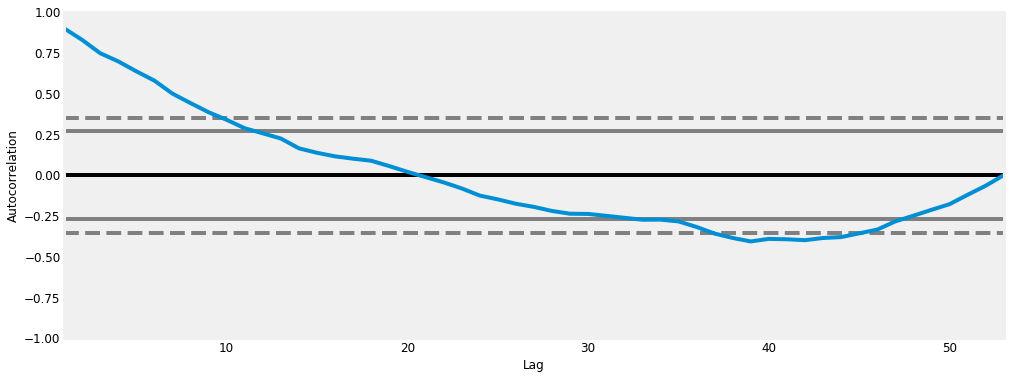

In [101]:
from pandas.plotting import autocorrelation_plot as ap

figure(figsize=(15, 6))
ap(meat)

- There is a postive correlation with the first 21 or so lags (see where the blue line hits zero)
- The correlation is significant from 1 to 8 lags (values that clear dotted line)
- Let's pick 1 as a starting point for the AR parameter

                             ARIMA Model Results                              
Dep. Variable:               D.amount   No. Observations:                   52
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -313.737
Method:                       css-mle   S.D. of innovations            100.778
Date:                Tue, 21 Jul 2020   AIC                            633.474
Time:                        09:13:47   BIC                            639.328
Sample:                    01-01-1962   HQIC                           635.719
                         - 01-01-2013                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             30.7261     10.138      3.031      0.004      10.856      50.597
ar.L1.D.amount    -0.3860      0.127     -3.051      0.004      -0.634      -0.138
                                    

/Users/wynnephilpott/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/Users/wynnephilpott/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


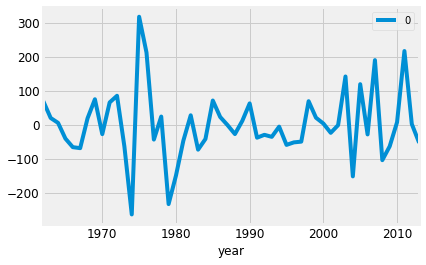

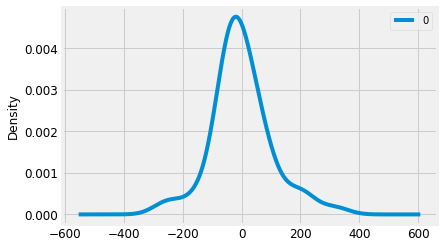

                0
count   52.000000
mean     0.514285
std    101.828578
min   -263.040668
25%    -49.957732
50%     -3.199014
75%     36.686823
max    317.223719


In [86]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(meat, order=(1,1,0)) ## Instaniate the model
model_fit = model.fit(disp=0) ## Train the model
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

- The mean centered around 0 indicates that there is not a bias in the predictions

## Forecast Model

The ARIMA model can be used to forecast future supply values. We will split the dataset into train and test sets, use train to fit the model, and generate a prediction for each element on the test set. We will go ahead and use a train-test split of 70%-30%.

predicted=1995.645742, expected=2081.000000
predicted=2089.745744, expected=2100.000000
predicted=2127.298145, expected=2139.000000
predicted=2162.832544, expected=2143.000000
predicted=2172.948127, expected=2183.000000
predicted=2206.367408, expected=2352.000000
predicted=2355.237465, expected=2178.000000
predicted=2252.922017, expected=2407.000000
predicted=2371.536503, expected=2333.000000
predicted=2394.344501, expected=2594.000000
predicted=2538.634865, expected=2432.000000
predicted=2541.012859, expected=2474.000000
predicted=2496.548792, expected=2508.000000
predicted=2533.961053, expected=2754.000000
predicted=2700.990920, expected=2704.000000
predicted=2767.484183, expected=2713.000000
Test RMSE: 109.863


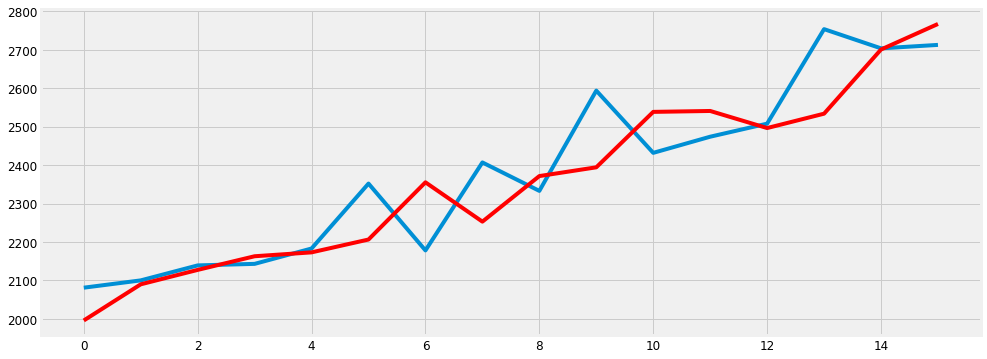

In [110]:
from sklearn.metrics import mean_squared_error

X = meat.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)
# plot
figure(figsize=(15, 6))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

- On average our predictions were off by 109.86 tonnes
- This is not to bad given that the standard deviation taken over all the years is 438.05 on a mean of of 1857.45

In [114]:
print(meat['amount'].mean())
print(meat['amount'].std())

1857.4528301886792
438.0527965210504
